# Module 13 Lab - Rule Based Machine Learning

## Directions


The due dates for each are indicated in the Syllabus and the course calendar. If anything is unclear, please email EN685.648@gmail.com the official email for the course or ask questions in the Lab discussion area on Blackboard.

The Labs also present technical material that augments the lectures and "book".  You should read through the entire lab at the start of each module.

<div style="background: mistyrose; color: firebrick; border: 2px solid darkred; padding: 5px; margin: 10px;">
Please follow the directions and make sure you provide the requested output. Failure to do so may result in a lower grade even if the code is correct or even 0 points.
</div>

1. Show all work/steps/calculations. Generate a Markdown/code cells for each answer.
2. You must submit your lab by the deadline to the Lab section of the Course Module where you downloaded this file from.
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

We talked about a wide variety of algorithms this module but we're going to concentrate on just two: Decision Trees and Random Forests.

---
## Problem 1.

Using the insurance data set, construct a Decision Tree to estimate charges using the Scikit Learn Library [Decision Tree](https://scikit-learn.org/stable/modules/tree.html). You should use validation curves to estimate the best tree depth. With this tree depth, perform 3 rounds of 10 fold cross validation to get a sense of generalization error and learning curves to estimate bias/variance trade-off.

Visualize the tree if possible. 

Compare with your linear regression results. Use Bayesian inference to test the difference of means.

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
import patsy

sns.set(style="whitegrid")

%matplotlib inline

### Construct a decision tree to estimate charges

In [2]:
# Load the data
data = pd.read_csv("insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Create the X, y matrices
formula = "charges ~ age + sex + bmi + children + smoker + region"
y, X = patsy.dmatrices(formula, data, return_type="matrix")

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# Split the data up
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

# Fit the tree
clf = tree.DecisionTreeRegressor(random_state=0)
clf = clf.fit(X_train, y_train)

In [6]:
# Predict some charges
clf.score(X_test, y_test)

0.7177470685672104

It seems that our super-basic decision tree scored $R^2 = 0.718$ on the training data. Definitely not as good as our linear regression, but also not terrible. 

### Use validation curves to estimate the best tree depth

In [7]:
from sklearn.model_selection import validation_curve

Let's try tree depths from 1 to 10

In [8]:
param_range = range(1, 11)
train_scores, test_scores = validation_curve(
    tree.DecisionTreeRegressor(),
    X,
    y,
    param_name="max_depth",
    param_range=param_range,
)

Alright, we've created training and test scores for all these tree depths. Let's see how they look.

In [9]:
def plot_validation_curve(train_scores, test_scores, param_name: str, estimator_name: str):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize = (10,6))
    plt.title(f"Validation Curve with {estimator_name}")
    plt.xlabel(param_name)
    plt.ylabel("$R^2$")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")

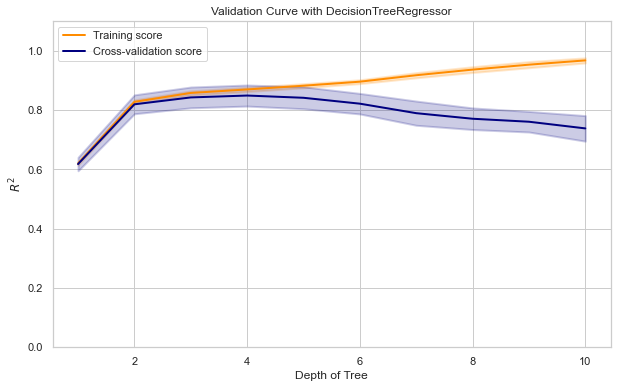

In [10]:
plot_validation_curve(train_scores, test_scores, param_name = "Depth of Tree", estimator_name = "DecisionTreeRegressor")

At a tree depth of 1, both training and test score around 0.6. We reach a maximum in both at a depth of 4. Above a depth of 4, cross-validation scores decrease, suggesting that we are overfitting. 

### Perform 3 rounds of 10 fold cross validation to get a sense of generalization error and learning curves to estimate bias/variance trade-off

---
## Problem 2.

Now use the [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) on the insurance data set. Use validation curves to optimize the hyperparameters. Estimate generalization error on 3 rounds of 10 fold cross validation. Instead of learning curves, examine the importance of the features. How does this compare with your linear regression from before?

In [11]:
from sklearn.ensemble import RandomForestRegressor

### Use validation curves to optimize the hyperparameters

In [12]:
# Fit the forest
regr = RandomForestRegressor(random_state=0)
regr = regr.fit(X_train, y_train.ravel())

In [13]:
# Predict some charges
regr.score(X_test, y_test)

0.8624710212872158

Off the bat, our random forest is getting $R^2 = 0.862$, pretty good for a first effort with no attempt at tuning the hyperparameters. 

Now to tune those hyperparameters. For sklearn's RandomForestRegressor class, those paramters are

- max_depth
- min_samples_split
- min_samples_leaf
- min_weight_fraction_leaf
- ... and more!

To start, let's do max_depth

In [14]:
param_range = range(1, 8)
train_scores, test_scores = validation_curve(
    RandomForestRegressor(),
    X,
    y.ravel(),
    param_name="max_depth",
    param_range=param_range,
)

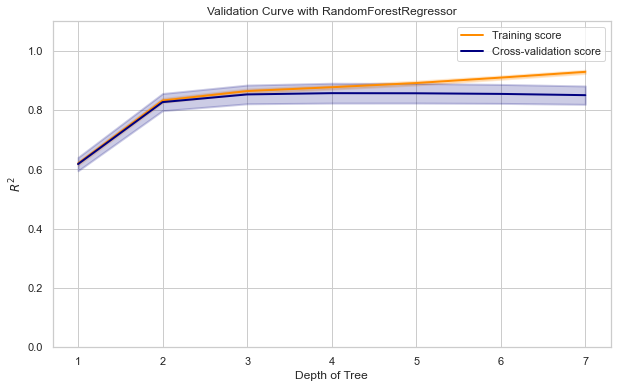

In [15]:
plot_validation_curve(train_scores, test_scores, param_name = "Depth of Tree", estimator_name = "RandomForestRegressor")

Interestingly, once the cross-validation maximum score is reached around a max depth of 3, it remains relatively constant after. Nevertheless, it seems the best tree depth is 3, as it's the fastest to calculate and has more or less equal $R^2$ with larger depths. 

Let's try another one with min_samples_split

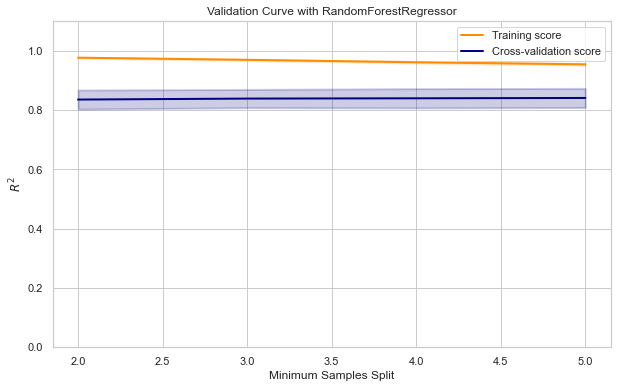

In [16]:
param_range = range(2, 6)
train_scores, test_scores = validation_curve(
    RandomForestRegressor(),
    X,
    y.ravel(),
    param_name="min_samples_split",
    param_range=param_range,
)
plot_validation_curve(train_scores, test_scores, param_name = "Minimum Samples Split", estimator_name = "RandomForestRegressor")

We see very little variation here. We'll stick with the default. 

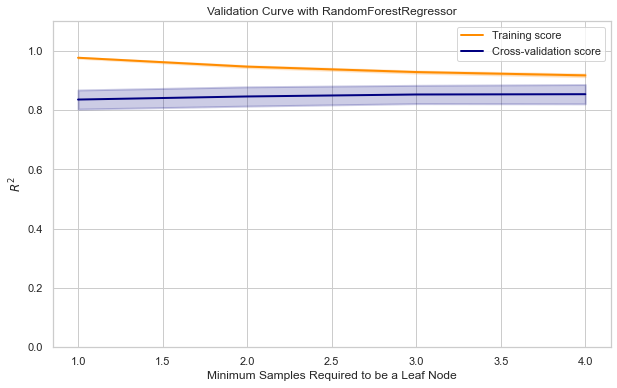

In [17]:
param_range = range(1, 5)
train_scores, test_scores = validation_curve(
    RandomForestRegressor(),
    X,
    y.ravel(),
    param_name="min_samples_leaf",
    param_range=param_range,
)
plot_validation_curve(train_scores, test_scores, param_name = "Minimum Samples Required to be a Leaf Node", estimator_name = "RandomForestRegressor")

The cross-validation score get's slightly higher, but training score decreases. 

I think we'll leave it there for testing out different hyperparameters. 

### How does this compare with your linear regression from before?
In general, the random forest and the decision tree performed to around the same level, given proper hyperparameter tuning. However, the random forest does take slightly longer to train. 

With linear regression, we were able to achieve an $R^2$ of 0.87, a little bit higher than what we saw with the random forest. The linear regression was more work to tune, but might be a more robust long term solution. If confident that the two would end up within a few percentage points of each other, I would probably choose the random forest for non-critical cases for it's ease of fitting. 